## Lecture 12: Parsing HTML

### James Sharpnack

- HTML is short for hypertext markup language
- descriptive, markup language
- used for modifying text with hidden tags
- browser reads the html file, with the tags and everything and turns it into text with different fonts, colors, structure, etc
- html has head (metadata, style, scripts) and body (main content to be displayed)
- just html will look outdated: https://www.conficturaindustries.com/

### Tags
&lt;TAG NAME&gt;STUFF BETWEEN TAGS&lt;\TAG NAME&gt;

- paragraph: &lt;p&gt;&lt;\p&gt;
- bold: &lt;strong&gt; text, create hyperlinks &lt;a href="site.html"&gt;
- create headers: &lt;h1&gt;&lt;h2&gt;
- create unordered lists: &lt;ul&gt;
- tables: &lt;table&gt;
- newline: &lt;br&gt;
- display image: &lt;img&gt;

### Style

- HTML only gives semantic structure to text, and does not specify or customize how these tags are visually represented
- CSS defines the visual meaning of the HTML, which is given in separate stylesheet files

```
.page-header {
  padding: 2rem 6rem; }
```

- tag.class selectors : select every tag with class
- tag#id selectors : the tag with id

### HTML structure

Tags such as `div, a, body, span` wrap more html with opening and closing tags 

```
<div class='example'>text in between</div>;
```

- hierarchical document structure
- If a tag is nested inside of another tag then it is the child (`<a>` is the child of `<p>`)
```
<p>Have you tried the <a href="salmon.html">salmon</a></p>
```
- tree structure is called the Document Object Model (DOM)
- LXML and BeautifulSoup parses the html string into this tree structure

## Breaking down data.gov climate data

Data.gov maintains a list of climate related datasets, but they are maintained by different agencies.  I'd like to get a sense of the number and diversity of these datasets, and which agencies they are coming from.

In [100]:
import requests
import requests_ftp
import requests_cache
import lxml
from bs4 import BeautifulSoup
from collections import Counter
from matplotlib import pyplot as plt
import pandas as pd
plt.style.use('ggplot')
requests_cache.install_cache('coll_cache')
%matplotlib inline

I went to data.gov and selected the climate data tab.  Here is the url: https://catalog.data.gov/dataset?groups=climate5434&page=1

Let's make a request for this page.

In [102]:
urlbase = "https://catalog.data.gov/dataset"
dataparams = {"groups":"climate5434","page":1}
climreq = requests.get(urlbase,params = dataparams)

In [103]:
climreq.url

'https://catalog.data.gov/dataset?groups=climate5434&page=1'

In [104]:
climhtml = climreq.text
clim = BeautifulSoup(climhtml,'lxml')

Here we imported the climate data catalogue (page 1), and turned it into a Beautiful Soup object.  We used the lxml parser, which is why we had to import lxml.  Let's look at the raw html.

In [105]:
print(climhtml[:500])

<!DOCTYPE html>
<!--[if IE 7]> <html lang="en" class="ie ie7"> <![endif]-->
<!--[if IE 8]> <html lang="en" class="ie ie8"> <![endif]-->
<!--[if IE 9]> <html lang="en" class="ie9"> <![endif]-->
<!--[if gt IE 8]><!--> <html lang="en"> <!--<![endif]-->
  <head>
    <!--[if lte ie 8]><script type="text/javascript" src="/fanstatic/vendor/:version:2020-02-07T22:53:07.54/html5.min.js"></script><![endif]-->
<link rel="stylesheet" type="text/css" href="/fanstatic/vendor/:version:2020-02-07T22:53:07.54/se


The BS object, and tags have other tags within then that you can access either as a class object (like below) or using the find method

In [106]:
clim.body

<body data-locale-root="https://catalog.data.gov/" data-site-root="https://catalog.data.gov/">
<div class="hide"><a href="#content">Skip to content</a></div>
<a class="hide" href="#content">Skip to content</a>
<header class="navbar navbar-static-top masthead">
<div class="container">
<div class="searchbox-row skip-navigation">
<div class="skip-link">
<a href="#">Jump to Content</a>
</div>
<div>
<form action="/dataset" class="search-form form-inline navbar-right navbar-nav col-sm-6 col-md-6 col-lg-6" method="get" role="search">
<div class="input-group">
<label class="hide" for="search-header">Search for:</label>
<input class="search-field form-control" id="search-header" name="q" onblur="if(value=='') value = 'Search Data.Gov'" onfocus="if(value=='Search Data.Gov') value = ''" placeholder="Search Data.Gov" type="search" value="Search Data.Gov"/> <span class="input-group-btn">
<button class="search-submit btn_new btn-default" type="submit">
<i class="fa fa-search"></i>
<span class="sr-on

In [34]:
collset_content = clim.find_all(name='div',attrs={'class':'dataset-content'})
collset1 = collset_content[0]
print(collset1.prettify())

<div class="dataset-content">
 <div class="organization-type-wrap">
  <span class="organization-type" data-organization-type="federal" title="Federal Government">
   <span>
    Federal
   </span>
  </span>
 </div>
 <h3 class="dataset-heading">
  <a href="/dataset/u-s-hourly-precipitation-data">
   U.S. Hourly Precipitation Data
  </a>
  <!-- Snippet snippets/popular.html start -->
  <span class="recent-views" title="855 recent views" xmlns="http://www.w3.org/1999/xhtml">
   <i class="fa fa-line-chart">
   </i>
   855 recent views
  </span>
  <!-- Snippet snippets/popular.html end -->
 </h3>
 <div class="notes">
  <p class="dataset-organization">
   National Oceanic and Atmospheric Administration, Department of Commerce —
  </p>
  <div>
   Hourly Precipitation Data (HPD) is digital data set DSI-3240, archived at the National Climatic Data Center (NCDC). The primary source of data for this file is...
  </div>
 </div>
 <ul class="dataset-resources unstyled">
  <li>
   <a class="label" dat

In [35]:
collset1.name, collset1.attrs, collset1['class']

('div', {'class': ['dataset-content']}, ['dataset-content'])

In [36]:
aset1 = collset1.find_all('a')
print(aset1[0])
print(aset1[1])

<a href="/dataset/u-s-hourly-precipitation-data">U.S. Hourly Precipitation Data</a>
<a class="label" data-format="html" data-organization="National Oceanic and Atmospheric Administration, Department of Commerce" href="https://data.nodc.noaa.gov/cgi-bin/iso?id=gov.noaa.ncdc:C00313" target="_blank">HTML</a>


Here is the title of the dataset collection, let's make a script to extract the title and href's from the 'a' tags.

In [37]:
aset1[0].text

'U.S. Hourly Precipitation Data'

In [38]:
aset1[0].attrs

{'href': '/dataset/u-s-hourly-precipitation-data'}

In [41]:
adict = {'label':[],'coll':[],'more':[]}
for a in aset1:
    try:
        adict[a['class'][0]].append(a['href'])
    except KeyError:
        adict['coll'].append(a['href'])
        collname = a.text.strip()

In [42]:
collname

'U.S. Hourly Precipitation Data'

In [43]:
adict

{'label': ['https://data.nodc.noaa.gov/cgi-bin/iso?id=gov.noaa.ncdc:C00313',
  'https://www.ncdc.noaa.gov/cdo-web/search?datasetid=PRECIP_HLY#',
  'https://gis.ncdc.noaa.gov/maps/ncei/cdo/hourly?layers=001',
  'ftp://ftp.ncdc.noaa.gov/pub/data/hourly_precip-3240/',
  'https://gis.ncdc.noaa.gov/arcgis/rest/services/cdo/precip_hly/MapServer',
  '/dataset/u-s-hourly-precipitation-data/resource/42d54fed-eb7a-4ec9-b7e2-7cd6db22b1bc'],
 'coll': ['/dataset/u-s-hourly-precipitation-data'],
 'more': ['/dataset/u-s-hourly-precipitation-data']}

We are also able to get the description component of the collection.

In [44]:
collnotes = collset1.find('div',attrs={'class':'notes'})

In [45]:
print(collnotes.prettify())

<div class="notes">
 <p class="dataset-organization">
  National Oceanic and Atmospheric Administration, Department of Commerce —
 </p>
 <div>
  Hourly Precipitation Data (HPD) is digital data set DSI-3240, archived at the National Climatic Data Center (NCDC). The primary source of data for this file is...
 </div>
</div>



In [46]:
collnotes.p.text.strip()

'National Oceanic and Atmospheric Administration, Department of Commerce —'

In [47]:
collnotes.div.text.strip()

'Hourly Precipitation Data (HPD) is digital data set DSI-3240, archived at the National Climatic Data Center (NCDC). The primary source of data for this file is...'

In [48]:
collorg = collnotes.p.text.strip()
colldesc = collnotes.div.text.strip()

Now that we have some code to process the collection html, let's create a def to modularize this section.

In [52]:
def process_collset(collset1):
    """
    Processes the data.gov html within the tags <div class = dataset-content>...
    Input: html string
    Output: tuple of title (string), organization (string), 
      description (string), hrefs (dictionary)
    """
    aset1 = collset1.find_all('a')
    adict = {'label':[],'coll':[],'more':[]}
    for a in aset1:
        try:
            adict[a['class'][0]].append(a['href'])
        except KeyError:
            adict['coll'].append(a['href'])
            collname = a.text.strip()
    collnotes = collset1.find('div',attrs={'class':'notes'})
    collorg = collnotes.p.text.strip()
    colldescdiv = collnotes.div
    if colldescdiv:
        colldesc = colldescdiv.text.strip()
    else:
        colldesc = ""
    return collname, collorg, colldesc, adict

In [53]:
help(process_collset)

Help on function process_collset in module __main__:

process_collset(collset1)
    Processes the data.gov html within the tags <div class = dataset-content>...
    Input: html string
    Output: tuple of title (string), organization (string), 
      description (string), hrefs (dictionary)



In [54]:
collname, collorg, colldesc, adict = process_collset(collset1)

In [55]:
collname

'U.S. Hourly Precipitation Data'

In [56]:
collorg

'National Oceanic and Atmospheric Administration, Department of Commerce —'

In [57]:
colldesc

'Hourly Precipitation Data (HPD) is digital data set DSI-3240, archived at the National Climatic Data Center (NCDC). The primary source of data for this file is...'

In [58]:
adict

{'label': ['https://data.nodc.noaa.gov/cgi-bin/iso?id=gov.noaa.ncdc:C00313',
  'https://www.ncdc.noaa.gov/cdo-web/search?datasetid=PRECIP_HLY#',
  'https://gis.ncdc.noaa.gov/maps/ncei/cdo/hourly?layers=001',
  'ftp://ftp.ncdc.noaa.gov/pub/data/hourly_precip-3240/',
  'https://gis.ncdc.noaa.gov/arcgis/rest/services/cdo/precip_hly/MapServer',
  '/dataset/u-s-hourly-precipitation-data/resource/42d54fed-eb7a-4ec9-b7e2-7cd6db22b1bc'],
 'coll': ['/dataset/u-s-hourly-precipitation-data'],
 'more': ['/dataset/u-s-hourly-precipitation-data']}

In [59]:
for collset in collset_content:
    collname = process_collset(collset)[0]
    print(collname)

U.S. Hourly Precipitation Data
Fruit and Vegetable Prices
NCDC Storm Events Database
National Hydrography Dataset (NHD) - USGS National Map Downloadable Data Collection
Soil Survey Geographic Database (SSURGO)
Global Surface Summary of the Day - GSOD
Feed Grains Database
Military Installations, Ranges, and Training Areas
NCEP North American Regional Reanalysis (NARR), for 1979 to Present
Census Data
MyPyramid Food Raw Data
USGS National Structures Dataset - USGS National Map Downloadable Data Collection
Toxics Release Inventory (TRI)
Global Forecast System (GFS) [0.5 Deg.]
1/9th Arc-second Digital Elevation Models (DEMs) - USGS National Map 3DEP Downloadable Data Collection
NOAA NEXt-Generation RADar (NEXRAD) Products
Internet Weather Source
Fertilizer Use and Price
Freight Analysis Framework
Integrated Surface Dataset (Global)


Let's modularize the queries from data.gov.

In [63]:
def clim_page(urlbase = "https://catalog.data.gov/dataset", groups="climate5434",
              page=1):
    """
    Queries the data.gov climate change data search for a specific page
    Input: urlbase, groups, page (strings)
    Output: list of dataset-content 
    """
    dataparams = {"groups":groups,"page":page}
    climreq = requests.get(urlbase,params = dataparams)
    clim_bs = BeautifulSoup(climreq.text,'lxml')
    collset_content = clim_bs.find_all(name='div',attrs={'class':'dataset-content'})
    return collset_content

In [64]:
clim = clim_page(page=2)

In [65]:
print([process_collset(c)[0] for c in clim])

['Organic Prices', 'Food Availability (Per Capita) Data System', 'Atlas of Rural and Small-Town America', 'Livestock & Meat International Trade Data', 'Dairy Data', "Water quality, meteorological, and nutrient data collected by the the National Estuarine Research Reserve System's System-wide Monitoring Program (NERRS SWMP) from January 1, 1995 to August 1, 2011 (NODC Accession 0052765)", 'International Surface Temperature Initiative (ISTI) Global Land Surface Temperature Databank - Stage 1 Monthly', 'Production, Supply, and Distribution Database', 'North American Mesoscale Forecast System (NAM) [12 km]', 'VegScape - Vegetative Condition Explorer', 'NOAA Optimum Interpolation 1/4 Degree Daily Sea Surface Temperature (OISST) Analysis, Version 2', 'Fisheries One Stop Shop Public Data 2009 - Present', 'Current National Weather Service Watches, Warnings, or Advisories for the United States', 'Clean Air Status and Trends Network (CASTNET): Ozone', 'Climate Prediction Center (CPC) Palmer Drou

Here we extract all of the pages from the climate group from data.gov.

In [66]:
page_num_max = 34
climate_colls = []
for page_num in range(1,page_num_max+1):
    try:
        clim = clim_page(page=page_num)
        if clim != None:
            climate_colls += [process_collset(c) for c in clim]
        else:
            break
    except requests.HTTPError:
        break

In [67]:
len(climate_colls)

404

In [68]:
climate_colls[0][3]

{'label': ['https://data.nodc.noaa.gov/cgi-bin/iso?id=gov.noaa.ncdc:C00313',
  'https://www.ncdc.noaa.gov/cdo-web/search?datasetid=PRECIP_HLY#',
  'https://gis.ncdc.noaa.gov/maps/ncei/cdo/hourly?layers=001',
  'ftp://ftp.ncdc.noaa.gov/pub/data/hourly_precip-3240/',
  'https://gis.ncdc.noaa.gov/arcgis/rest/services/cdo/precip_hly/MapServer',
  '/dataset/u-s-hourly-precipitation-data/resource/42d54fed-eb7a-4ec9-b7e2-7cd6db22b1bc'],
 'coll': ['/dataset/u-s-hourly-precipitation-data'],
 'more': ['/dataset/u-s-hourly-precipitation-data']}

I'll build a dataframe so that I can count the data collections by organization.

In [69]:
climate_df = pd.DataFrame({'name':c[0],'organization':c[1],'description':c[2]}
                          for c in climate_colls)

In [70]:
climate_df

,name,organization,description
0,U.S. Hourly Precipitation Data,National Oceanic and Atmospheric Administratio...,Hourly Precipitation Data (HPD) is digital dat...
1,Fruit and Vegetable Prices,Department of Agriculture —,How much do fruits and vegetables cost? ERS es...
2,NCDC Storm Events Database,National Oceanic and Atmospheric Administratio...,Storm Data is provided by the National Weather...
3,National Hydrography Dataset (NHD) - USGS Nati...,"U.S. Geological Survey, Department of the Inte...",The USGS National Hydrography Dataset (NHD) Do...
4,Soil Survey Geographic Database (SSURGO),Department of Agriculture —,This dataset is a digital soil survey and gene...
...,...,...,...
399,Superfund Site Information,U.S. Environmental Protection Agency —,This asset includes a number of individual dat...
400,EnviroAtlas - Percent of Each 12-Digit HUC in ...,U.S. Environmental Protection Agency —,This EnviroAtlas dataset shows the percent of ...
401,ICLUS v1.3 Housing Density for the Conterminou...,U.S. Environmental Protection Agency —,Climate and land-use change are major componen...
402,CDC Social Vulnerability Index (SVI) Mapping D...,U.S. Department of Health & Human Services —,The interactive maps are visual representation...


In [71]:
org_count = climate_df.groupby('organization').count()

In [72]:
org_count.sort_values(by='name',ascending=False)

,name,description
organization,,
"National Oceanic and Atmospheric Administration, Department of Commerce —",182,182
Department of Agriculture —,61,61
U.S. Environmental Protection Agency —,52,52
National Aeronautics and Space Administration —,40,40
Department of Energy —,13,13
U.S. Department of Health & Human Services —,12,12
"U.S. Geological Survey, Department of the Interior —",11,11
"US Census Bureau, Department of Commerce —",9,9
Department of Commerce —,6,6


In [73]:
org_count_abbr = org_count[org_count['name'] > 20]

In [74]:
rem_count = org_count[org_count['name'] <= 20].sum()[0]

In [75]:
type(rem_count)

numpy.int64

In [76]:
org_count_abbr = org_count_abbr.append(pd.DataFrame({'name':[rem_count]}, 
                                                    index=['Other']))
org_count_abbr = org_count_abbr[['name']].rename(columns={'name':'count'})

/home/jsharpna/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:7123: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


In [77]:
org_count_abbr

,count
Department of Agriculture —,61
National Aeronautics and Space Administration —,40
"National Oceanic and Atmospheric Administration, Department of Commerce —",182
U.S. Environmental Protection Agency —,52
Other,69


<Figure size 720x576 with 0 Axes>

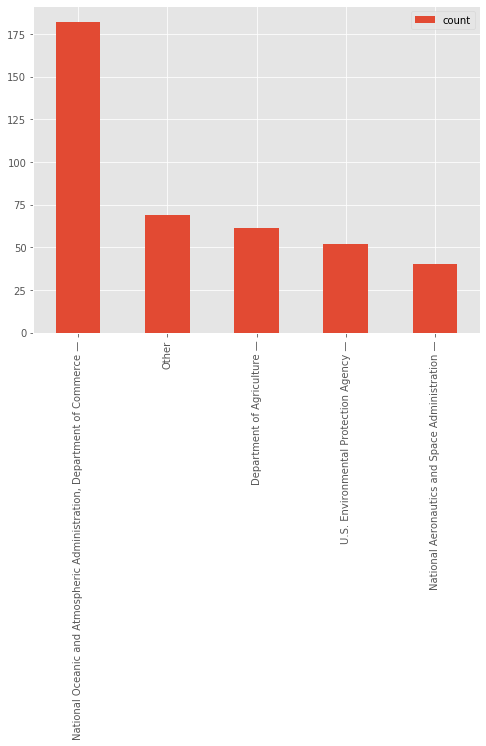

In [78]:
plt.figure(figsize=(10,8))
_ = org_count_abbr.sort_values(by='count',ascending=False).plot(y='count',kind='bar',figsize=(8,6))

In [79]:
org_sorted = org_count_abbr.sort_values(by='count',ascending=False).index.values

# Tracking the status of datasets

The goal of this section is to look at the status of the datasets, and if they are able to be downloaded by following the link.  We can do this by checking the header for a http or ftp request.  Let's make some defs to query the dataset urls.  The first is for converting relative paths to urls, and the second returns the status of the request to that url.

In [80]:
def reltoabs(url,urlbase = "https://catalog.data.gov"):
    """
    Input: url string
    Output: url string
    """
    if url[0]=='/':
        return urlbase+url
    if (url[:6] == "http:/") and (not url[6] == "/"):
        return "http://" + url[6:]
    return url

In [81]:
def testurl(url):
    """
    Input: url
    Output: request status code
    """
    try:
        if url[:4] == 'http':
            r = requests.head(url)
            return r.status_code
        if url[:3] == 'ftp':
            requests_ftp.monkeypatch_session()
            s = requests.Session()
            resp = s.list(url)
            return resp.status_code
    except requests.ConnectionError:
        return None

In [82]:
[a for a in climate_colls[0][3]['label']]

['https://data.nodc.noaa.gov/cgi-bin/iso?id=gov.noaa.ncdc:C00313',
 'https://www.ncdc.noaa.gov/cdo-web/search?datasetid=PRECIP_HLY#',
 'https://gis.ncdc.noaa.gov/maps/ncei/cdo/hourly?layers=001',
 'ftp://ftp.ncdc.noaa.gov/pub/data/hourly_precip-3240/',
 'https://gis.ncdc.noaa.gov/arcgis/rest/services/cdo/precip_hly/MapServer',
 '/dataset/u-s-hourly-precipitation-data/resource/42d54fed-eb7a-4ec9-b7e2-7cd6db22b1bc']

In [89]:
urlstats=[]
errors = []
for coll in climate_colls:
    urlstattemp = []
    for urlrel in coll[3]['label']:
        try:
            url = reltoabs(urlrel)
            urlstatus = testurl(url)
            urlstattemp += [urlstatus]
        except BaseException as e:
            print(urlrel)
            errors.append((e,urlrel))
    urlstats.append(urlstattemp)

ftp://sidads.colorado.edu/pub/DATASETS/NOAA/G02172/
ftp://sidads.colorado.edu/pub/DATASETS/NOAA/G00807
ftp://sidads.colorado.edu/DATASETS/NOAA/G01378
ftp://sidads.colorado.edu/pub/DATASETS/NOAA/G01360
ftp://sidads.colorado.edu/pub/DATASETS/NOAA/G02196/
ftp://sidads.colorado.edu/pub/DATASETS/NOAA/G02182/
ftp://sidads.colorado.edu/pub/DATASETS/NOAA/G10006/
ftp://sidads.colorado.edu/pub/DATASETS/NOAA/G02189/
ftp://sidads.colorado.edu/pub/DATASETS/NOAA/G01358/
ftp://sidads.colorado.edu/DATASETS/NOAA/G02203/
ftp://sidads.colorado.edu/pub/DATASETS/NOAA/G02171/
ftp://sidads.colorado.edu/pub/DATASETS/NOAA/G10008/
ftp://sidads.colorado.edu/pub/DATASETS/NOAA/G01130/
ftp://sidads.colorado.edu/DATASETS/NOAA/G02135/


In [90]:
len(errors)

14

In [91]:
errors[0]

(ValueError("invalid literal for int() with base 10: '226-Options:'"),
 'ftp://sidads.colorado.edu/pub/DATASETS/NOAA/G02172/')

In [92]:
len(urlstats)

404

We can see that urlstats contains the request status of the urls that are listed on data.gov.  So let's make a def that converts each list of status returns into a dict of counts of each type.  This way we can pass it to pd.DataFrame

In [93]:
urlstats[0:10]

[[200, 200, 200, 226, 500, 200],
 [301],
 [200, 200, 200, 200, 200, 200],
 [200, 226, 200, 200, 200, 200],
 [302],
 [200, 226, 301, 200, 500, 200],
 [301, 404, 404, 404],
 [307],
 [503, 226, 226, 200, 200, 302],
 [301]]

In [94]:
def convstatnames(stats):
    """Return a dictionary of counts"""
    sdict = dict(Counter(stats))
    return {'status_'+str(a):b for a,b in sdict.items()}

stat_df = pd.DataFrame([convstatnames(stats) for stats in urlstats])
stat_df = stat_df.fillna(0)
stat_df.head()

failedstatus = ['status_400','status_404','status_405','status_503','status_None']
stat_df['failed ratio'] = stat_df[failedstatus].sum(axis=1)/stat_df.sum(axis=1)

We've also created a variable which is the proportion of urls that returned a status in the 400's or 500's or None.  Let's now join this against the climate_df to get one DataFrame of all unique combinations of failed ratio and organization.  Retain only the most common organizations.

In [95]:
climate_df = climate_df.join(stat_df)
climate_failed = climate_df.groupby(['organization','failed ratio'])
failed_count = climate_failed.count()[['name']].rename(columns={'name':'count'})
failed_count = failed_count.reset_index()
red_orgs = org_count[org_count['name'] > 20].index
failed_count_red = failed_count[[org in red_orgs for org in failed_count['organization']]]
failed_count_red.head()

,organization,failed ratio,count
0,Department of Agriculture —,0.000000,53
1,Department of Agriculture —,0.166667,1
2,Department of Agriculture —,0.333333,1
3,Department of Agriculture —,0.500000,2
4,Department of Agriculture —,0.750000,1


In [96]:
climate_df.head()

,name,organization,description,status_200,status_226,status_500,status_301,status_302,status_404,status_307,status_503,status_504,status_400,status_None,status_405,status_403,status_502,status_401,failed ratio
0,U.S. Hourly Precipitation Data,National Oceanic and Atmospheric Administratio...,Hourly Precipitation Data (HPD) is digital dat...,4.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,Fruit and Vegetable Prices,Department of Agriculture —,How much do fruits and vegetables cost? ERS es...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,NCDC Storm Events Database,National Oceanic and Atmospheric Administratio...,Storm Data is provided by the National Weather...,6.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,National Hydrography Dataset (NHD) - USGS Nati...,"U.S. Geological Survey, Department of the Inte...",The USGS National Hydrography Dataset (NHD) Do...,5.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,Soil Survey Geographic Database (SSURGO),Department of Agriculture —,This dataset is a digital soil survey and gene...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [97]:
org_numbers = {org_sorted[i]:i+1 for i in range(len(org_sorted))}
failed_count_red['org number'] = failed_count_red['organization'].apply(lambda o: org_numbers[o])

/home/jsharpna/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [98]:
failed_count_red.head()

,organization,failed ratio,count,org number
0,Department of Agriculture —,0.000000,53,3
1,Department of Agriculture —,0.166667,1,3
2,Department of Agriculture —,0.333333,1,3
3,Department of Agriculture —,0.500000,2,3
4,Department of Agriculture —,0.750000,1,3


1: National Oceanic and Atmospheric Administration, Department of Commerce —
2: Other
3: Department of Agriculture —
4: U.S. Environmental Protection Agency —
5: National Aeronautics and Space Administration —


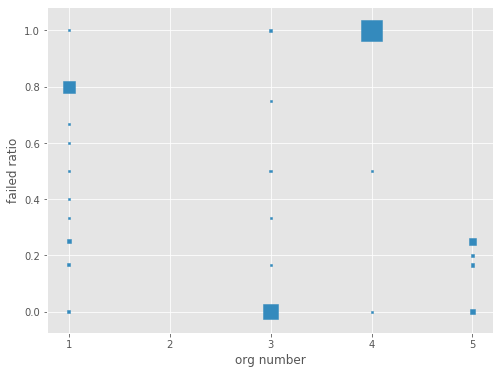

In [99]:
from operator import itemgetter
norgs=len(org_numbers)
_ = failed_count_red.plot(x = 'org number',y = 'failed ratio',xticks=range(1,norgs+1),
                      s=failed_count['count']*4,kind='scatter',marker='s',figsize=(8,6))
for orgname,i in sorted(org_numbers.items(),key=itemgetter(1)):
    print("{}: {}".format(i,orgname))